In [1]:
## rpart model gave an accuracy of 67% using AUC-ROC method and needs to be improved
## Let's start again

In [3]:
train = fread("train.csv", na.strings = c(""," ", NA), stringsAsFactors = T)
test = fread("test.csv", na.strings = c(""," " ,NA), stringsAsFactors = T)

Read 532428 rows and 45 (of 45) columns from 0.134 GB file in 00:00:07
Read 354951 rows and 44 (of 44) columns from 0.089 GB file in 00:00:04


In [4]:
test$loan_status = NA
total = rbindlist(list(train,test), fill = T)

In [5]:
total[,prop.table(table(pymnt_plan))]

pymnt_plan
           n            y 
9.999887e-01 1.126914e-05 

In [6]:
total[,prop.table(table(initial_list_status))]

initial_list_status
        f         w 
0.5148285 0.4851715 

In [7]:
length(unique(total$emp_title))

[1] 289208

In [8]:
str(total)

Classes 'data.table' and 'data.frame':	887379 obs. of  45 variables:
 $ member_id                  : int  58189336 70011223 70255675 1893936 7652106 10247268 8089625 23043116 45900933 41272507 ...
 $ loan_amnt                  : int  14350 4800 10000 15000 16000 15000 5000 6000 6000 34550 ...
 $ funded_amnt                : int  14350 4800 10000 15000 16000 15000 5000 6000 6000 34550 ...
 $ funded_amnt_inv            : num  14350 4800 10000 15000 16000 ...
 $ term                       : Factor w/ 2 levels "36 months","60 months": 1 1 1 1 1 1 1 1 1 2 ...
 $ batch_enrolled             : Factor w/ 206 levels "BAT1104812","BAT1135695",..: NA 9 9 80 35 32 NA NA 64 73 ...
 $ int_rate                   : num  19.19 10.99 7.26 19.72 10.64 ...
 $ grade                      : Factor w/ 7 levels "A","B","C","D",..: 5 2 1 4 2 1 1 2 3 4 ...
 $ sub_grade                  : Factor w/ 35 levels "A1","A2","A3",..: 23 9 4 20 7 5 4 6 14 19 ...
 $ emp_title                  : Factor w/ 289207 levels "\tA

In [9]:
## Convert the variables with large number of levels into integers otherwise with this many levels, logistic regression model
## will give memory errors
total$title = as.integer(total$title)
total$emp_title = as.integer(total$emp_title)

In [10]:
levels(total$term)[levels(total$term) == "36 months"] = 36
levels(total$term)[levels(total$term) == "60 months"] = 60

In [11]:
levels(total$grade)[levels(total$grade) == "A"] = 0
levels(total$grade)[levels(total$grade) == "B"] = 1
levels(total$grade)[levels(total$grade) == "C"] = 2
levels(total$grade)[levels(total$grade) == "D"] = 3
levels(total$grade)[levels(total$grade) == "E"] = 4
levels(total$grade)[levels(total$grade) == "F"] = 5
levels(total$grade)[levels(total$grade) == "G"] = 6

In [12]:
table(total$grade)


     0      1      2      3      4      5      6 
148202 254535 245860 139542  70705  23046   5489 

In [13]:
total$sub_grade = as.integer(total$sub_grade) - 1
total$sub_grade = as.factor(total$sub_grade)

In [14]:
table(total$sub_grade)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
22913 22485 23457 34531 44816 44972 48781 56323 55626 48833 53387 52236 50161 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
48857 41219 36238 29803 26554 25558 21389 18268 17004 14134 11724  9575  7218 
   26    27    28    29    30    31    32    33    34 
 5392  4433  3409  2594  1871  1398   981   663   576 

In [15]:
## 1 is substracted from each variable just to make factors start from 0 instead of 1
total$emp_length = as.integer(total$emp_length) - 1
total$emp_length = as.factor(total$emp_length)

In [16]:
table(total$emp_length)


     0      1      2      3      4      5      6      7      8      9     10 
 57095 291569  78870  70026  52529  55704  42950  44594  43955  34657  70605 
    11 
 44825 

In [17]:
total$home_ownership = as.integer(total$home_ownership) - 1
total$home_ownership = as.integer(total$home_ownership)

In [18]:
total$verification_status = as.integer(total$verification_status) - 1
total$verification_status = as.factor(total$verification_status)

In [19]:
total$purpose = as.integer(total$purpose) - 1
total$purpose = as.factor(total$purpose)

In [20]:
## It is not converted to factors because it has large number of levels
total$addr_state = as.integer(total$addr_state)

In [21]:
total$initial_list_status = as.integer(total$initial_list_status) - 1
total$initial_list_status = as.factor(total$initial_list_status)

In [22]:
total$application_type = as.integer(total$application_type) - 1
total$application_type = as.factor(total$application_type)

In [23]:
total$last_week_pay = as.integer(total$last_week_pay) - 1
total$last_week_pay = as.factor(total$last_week_pay)

In [24]:
## For now let's remove the rows with large number of NA's and rows which does not seem very relevent at first sight
total$tot_coll_amt=NULL
total$tot_cur_bal=NULL
total$total_rev_hi_lim=NULL
total$emp_title=NULL
total$member_id = NULL
total$mths_since_last_delinq = NULL
total$mths_since_last_record = NULL
total$mths_since_last_major_derog = NULL
total$verification_status_joint = NULL
total$batch_enrolled=NULL
total$desc=NULL
total$zip_code=NULL

In [25]:
summary(total)

   loan_amnt      funded_amnt    funded_amnt_inv term           int_rate    
 Min.   :  500   Min.   :  500   Min.   :    0   36:621125   Min.   : 5.32  
 1st Qu.: 8000   1st Qu.: 8000   1st Qu.: 8000   60:266254   1st Qu.: 9.99  
 Median :13000   Median :13000   Median :13000               Median :12.99  
 Mean   :14755   Mean   :14742   Mean   :14702               Mean   :13.25  
 3rd Qu.:20000   3rd Qu.:20000   3rd Qu.:20000               3rd Qu.:16.20  
 Max.   :35000   Max.   :35000   Max.   :35000               Max.   :28.99  
                                                                            
 grade        sub_grade        emp_length     home_ownership    annual_inc     
 0:148202   7      : 56323   1      :291569   Min.   :0.000   Min.   :      0  
 1:254535   8      : 55626   2      : 78870   1st Qu.:1.000   1st Qu.:  45000  
 2:245860   10     : 53387   10     : 70605   Median :3.000   Median :  65000  
 3:139542   11     : 52236   3      : 70026   Mean   :2.901   Me

In [26]:
## Let's deal with missing values
## For now let's replace them with median
total$annual_inc[is.na(total$annual_inc)] = 65000
total$title[is.na(total$title)] = 10358
total$delinq_2yrs[is.na(total$delinq_2yrs)] = 0
total$inq_last_6mths[is.na(total$inq_last_6mths)] = 0
total$open_acc[is.na(total$open_acc)] = 11
total$pub_rec[is.na(total$pub_rec)] = 0
total$revol_util[is.na(total$revol_util)] = 56
total$total_acc[is.na(total$total_acc)] = 24
total$collections_12_mths_ex_med[is.na(total$collections_12_mths_ex_med)] = 0.01438
total$acc_now_delinq[is.na(total$acc_now_delinq)] = 0

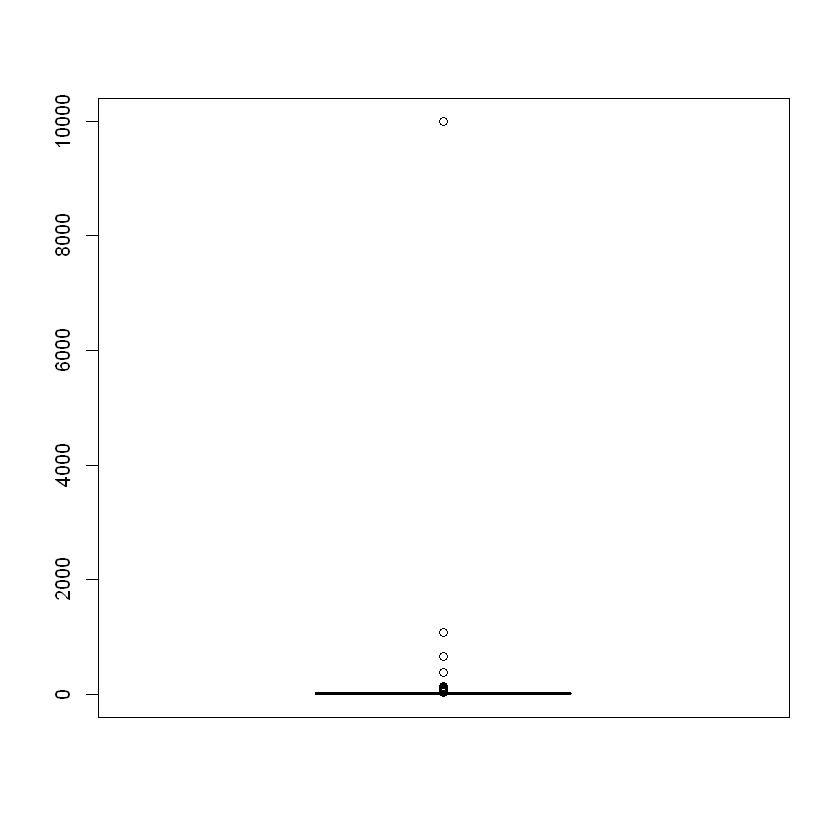

In [27]:
## let's look at some of the columns having outliers
boxplot(total$dti)

In [28]:
## replace the outliers with the mean of the data
total$dti[total$dti>50] = 18.16

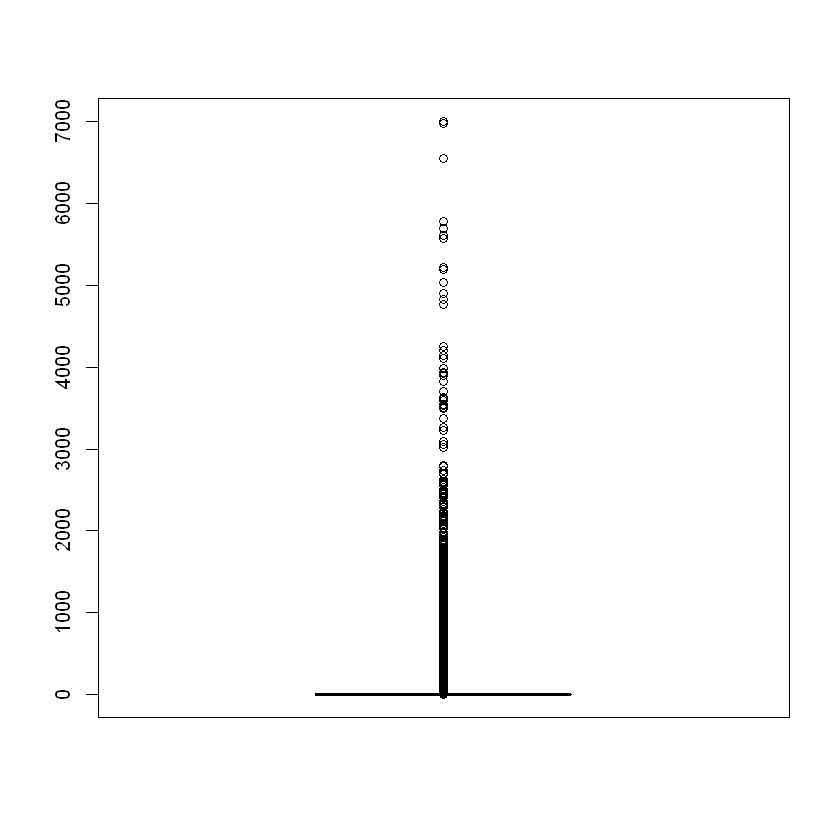

In [29]:
boxplot(total$collection_recovery_fee)

In [30]:
## too many outliers. We will deal with them later. For now let's remove this column
total$collection_recovery_fee = NULL

In [32]:
h2o.init(nthreads = -1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\MANISH~1\AppData\Local\Temp\RtmpMzeWlP/h2o_Manish_K_Sihag_started_from_r.out
    C:\Users\MANISH~1\AppData\Local\Temp\RtmpMzeWlP/h2o_Manish_K_Sihag_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 489 milliseconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    1 month and 5 days  
    H2O cluster name:           H2O_started_from_R_Manish_K_Sihag_chg016 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.87 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 



In [33]:
trainNew = head(total,nrow(train))
testNew = tail(total,nrow(test))

In [34]:
testNew$loan_status = NULL

In [35]:
## Convert the datasets into h2o supported environment
train.h2o = as.h2o(trainNew)
test.h2o = as.h2o(testNew)

  |======================================================================| 100%
  |======================================================================| 100%


In [36]:
train.h2o$loan_status = as.factor(train.h2o$loan_status)

In [37]:
y.dep = "loan_status"
x.indep = setdiff(colnames(train.h2o), c(y.dep,"member_id"))

In [38]:
## Check the size of objects and remove the unnecessary one to save memory
sort(sapply(ls(),function(x){object.size(get(x))}))

y.dep   x.indep  test.h2o train.h2o   testNew  trainNew      test     train 
      104      2056     25192     26216  68170656 104376072 105309304 158885848 
    total 
173946528

In [39]:
rm(testNew,trainNew,total)

In [40]:
regression.model = h2o.glm( y = y.dep, x = x.indep, training_frame = train.h2o, family = "binomial")

  |======================================================================| 100%


In [41]:
h2o.performance(regression.model)

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.1227991
RMSE:  0.350427
LogLoss:  0.3929786
Mean Per-Class Error:  0.2489193
AUC:  0.8375452
Gini:  0.6750904
R^2:  0.3195838
Null Deviance:  582272.6
Residual Deviance:  418465.6
AIC:  418757.6

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0      1    Error            Rate
0      350227  56374 0.138647   =56374/406601
1       45196  80631 0.359192   =45196/125827
Totals 395423 137005 0.190768  =101570/532428

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.304239 0.613555 217
2                       max f2  0.165167 0.698717 293
3                 max f0point5  0.458394 0.658996 150
4                 max accuracy  0.446269 0.833559 154
5                max precision  0.987922 0.990099   2
6                   max recall  0.000070 1.000000 399
7              max specificity

In [42]:
predict.reg = as.data.frame(h2o.predict(regression.model, test.h2o, type = "response"))

  |======================================================================| 100%


In [43]:
summary(predict.reg)

 predict          p0                 p1         
 0:259102   Min.   :0.000055   Min.   :0.00000  
 1: 95849   1st Qu.:0.676214   1st Qu.:0.08509  
            Median :0.835712   Median :0.16429  
            Mean   :0.753822   Mean   :0.24618  
            3rd Qu.:0.914910   3rd Qu.:0.32379  
            Max.   :1.000000   Max.   :0.99994  

In [44]:
sub_reg = data.frame(member_id = test$member_id, loan_status = predict.reg$p1)

In [45]:
fwrite(sub_reg, "sub.reg.csv", row.names = F)

In [46]:
## Before moving on I applied deep learning model just out of curiosity and it gave a very surprising accuracy

In [47]:
## these parameters are choosen at random
dlearning.model = h2o.deeplearning(y = y.dep,
             x = x.indep,
             training_frame = train.h2o,
             epoch = 60,
             hidden = c(100,100),
             activation = "Rectifier",
             seed = 1122)

  |======================================================================| 100%


In [48]:
h2o.performance(dlearning.model)

H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9895 samples **

MSE:  0.07680016
RMSE:  0.2771284
LogLoss:  0.2734106
Mean Per-Class Error:  0.1536873
AUC:  0.9208211
Gini:  0.8416421

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
          0    1    Error       Rate
0      7228  374 0.049198  =374/7602
1       592 1701 0.258177  =592/2293
Totals 7820 2075 0.097625  =966/9895

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.382614 0.778846 191
2                       max f2  0.207883 0.795143 251
3                 max f0point5  0.606114 0.832690 134
4                 max accuracy  0.488699 0.903487 163
5                max precision  0.991030 0.987179   6
6                   max recall  0.000044 1.000000 399
7              max specificity  0.999782 0.999605   0
8             max

In [49]:
pred.dlearning = as.data.frame(h2o.predict(dlearning.model, test.h2o, type = "response"))

  |======================================================================| 100%


In [50]:
summary(pred.dlearning)

 predict          p0               p1         
 0:279299   Min.   :0.0000   Min.   :0.00000  
 1: 75652   1st Qu.:0.7262   1st Qu.:0.03631  
            Median :0.9170   Median :0.08298  
            Mean   :0.7593   Mean   :0.24070  
            3rd Qu.:0.9637   3rd Qu.:0.27379  
            Max.   :1.0000   Max.   :1.00000  

In [51]:
submission = data.frame(member_id = test$member_id, loan_status = pred.dlearning$p1)

In [53]:
fwrite(submission, "sub.dlearning.csv", row.names = F)

In [54]:
## This model reached a accuracy of 89%!! woah!!